<a href="https://colab.research.google.com/github/sidvsukhi/Text-Summarization-of-T-C/blob/main/Project_ContractNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import json
  
# Opening JSON file
file_data = open('./train.json')

data = json.load(file_data)

In [26]:
df = pd.DataFrame(data['documents'])
df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [27]:
df['annotation_sets'] = df['annotation_sets'].apply(lambda x: x[0]['annotations'])
df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [28]:
def func(spans, annotation_sets, text):
  di = {}
  i = 0
  for key, item in annotation_sets.items():
    ann_span_new = []
    for ann_span in item['spans']:
      ann_span_new.append(text[spans[ann_span][0]:spans[ann_span][1]])
    di[key] = {'choice': item['choice'], 'spans': ann_span_new}
    i+=1

  return di

In [29]:
df['ann_new'] = df.apply(lambda x: func(x.spans, x.annotation_sets, x.text), axis=1)

In [30]:
pd.DataFrame(df['ann_new'].tolist())

,nda-11,nda-16,nda-15,nda-10,nda-2,nda-1,nda-19,nda-12,nda-20,nda-3,nda-18,nda-7,nda-17,nda-8,nda-13,nda-5,nda-4
0,"{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['5. All Con...","{'choice': 'Entailment', 'spans': ['4. Nothing...","{'choice': 'Entailment', 'spans': ['11. The Re...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['1. “Confid...","{'choice': 'Entailment', 'spans': ['Either Par...","{'choice': 'Entailment', 'spans': ['The Recipi...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['1. “Confid...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['2.3 Provid...","{'choice': 'Entailment', 'spans': ['The Recipi...","{'choice': 'Entailment', 'spans': ['The Recipi...","{'choice': 'Entailment', 'spans': ['The Recipi...","{'choice': 'Entailment', 'spans': ['2.3 Provid...","{'choice': 'Entailment', 'spans': ['The Recipi..."
1,"{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Any and al...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Contradiction', 'spans': ['“Confid...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Notwithsta...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Contradiction', 'spans': ['At Orga...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Contradiction', 'spans': ['Mentor ...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['If Mentor ...","{'choice': 'Entailment', 'spans': ['Confidenti...","{'choice': 'Contradiction', 'spans': ['Mentor ...","{'choice': 'Entailment', 'spans': ['Mentor sha..."
2,"{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Upon termi...","{'choice': 'Entailment', 'spans': ['This Agree...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['The provis...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Notwithsta...","{'choice': 'Entailment', 'spans': ['“Confident...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Contradiction', 'spans': ['Each Pa...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['(a) In the...","{'choice': 'Entailment', 'spans': ['Notwithsta...","{'choice': 'Entailment', 'spans': ['Notwithsta...","{'choice': 'Entailment', 'spans': ['Each Parti..."
3,"{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['5. No Furt...","{'choice': 'Entailment', 'spans': ['The existe...","{'choice': 'Contradiction', 'spans': ['Confide...","{'choice': 'Contradiction', 'spans': ['1. Conf...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Confidenti...","{'choice': 'Contradiction', 'spans': ['Upon th...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['Confidenti...","{'choice': 'Entailment', 'spans': ['Confidenti...","{'choice': 'Entailment', 'spans': ['The Receiv...","{'choice': 'Entailment', 'spans': ['Each party..."
4,"{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['2. Upon th...","{'choice': 'Entailment', 'spans': ['The Data R...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['2. Upon th...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['3. In the ...","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'NotMentioned', 'spans': []}","{'choice': 'Entailment', 'spans': ['1. Only th...","{'choice': 'Contradiction', 'spans': ['Except 

In [31]:
for key, value in data.items():
    print('Types of document: ', key,', Number of documents: ', len(value))

Types of document:  documents , Number of documents:  423
Types of document:  labels , Number of documents:  17


In [32]:
print(data['labels'])

{'nda-11': {'short_description': 'No reverse engineering', 'hypothesis': "Receiving Party shall not reverse engineer any objects which embody Disclosing Party's Confidential Information."}, 'nda-16': {'short_description': 'Return of confidential information', 'hypothesis': 'Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.'}, 'nda-15': {'short_description': 'No licensing', 'hypothesis': 'Agreement shall not grant Receiving Party any right to Confidential Information.'}, 'nda-10': {'short_description': 'Confidentiality of Agreement', 'hypothesis': 'Receiving Party shall not disclose the fact that Agreement was agreed or negotiated.'}, 'nda-2': {'short_description': 'None-inclusion of non-technical information', 'hypothesis': 'Confidential Information shall only include technical information.'}, 'nda-1': {'short_description': 'Explicit identification', 'hypothesis': 'All Confidential Information shall be expressly identified by the D

In [33]:
document_annotations = {}

for document in data['documents']:
    temp_annotations = {}
    for key, value in document['annotation_sets'][0]['annotations'].items():
        temp_annotations[key] = len(value['spans'])
    document_annotations[document['id']] = temp_annotations

document_annotations

{34: {'nda-11': 0,
  'nda-16': 2,
  'nda-15': 1,
  'nda-10': 1,
  'nda-2': 0,
  'nda-1': 1,
  'nda-19': 1,
  'nda-12': 2,
  'nda-20': 0,
  'nda-3': 1,
  'nda-18': 0,
  'nda-7': 2,
  'nda-17': 1,
  'nda-8': 1,
  'nda-13': 2,
  'nda-5': 3,
  'nda-4': 1},
 86: {'nda-11': 0,
  'nda-16': 0,
  'nda-15': 1,
  'nda-10': 0,
  'nda-2': 1,
  'nda-1': 0,
  'nda-19': 1,
  'nda-12': 0,
  'nda-20': 3,
  'nda-3': 0,
  'nda-18': 0,
  'nda-7': 1,
  'nda-17': 0,
  'nda-8': 1,
  'nda-13': 2,
  'nda-5': 1,
  'nda-4': 1},
 87: {'nda-11': 0,
  'nda-16': 1,
  'nda-15': 1,
  'nda-10': 0,
  'nda-2': 0,
  'nda-1': 0,
  'nda-19': 1,
  'nda-12': 0,
  'nda-20': 1,
  'nda-3': 2,
  'nda-18': 0,
  'nda-7': 3,
  'nda-17': 0,
  'nda-8': 3,
  'nda-13': 2,
  'nda-5': 1,
  'nda-4': 6},
 88: {'nda-11': 0,
  'nda-16': 0,
  'nda-15': 2,
  'nda-10': 1,
  'nda-2': 1,
  'nda-1': 1,
  'nda-19': 0,
  'nda-12': 2,
  'nda-20': 1,
  'nda-3': 0,
  'nda-18': 0,
  'nda-7': 0,
  'nda-17': 0,
  'nda-8': 2,
  'nda-13': 3,
  'nda-5': 1,
  '

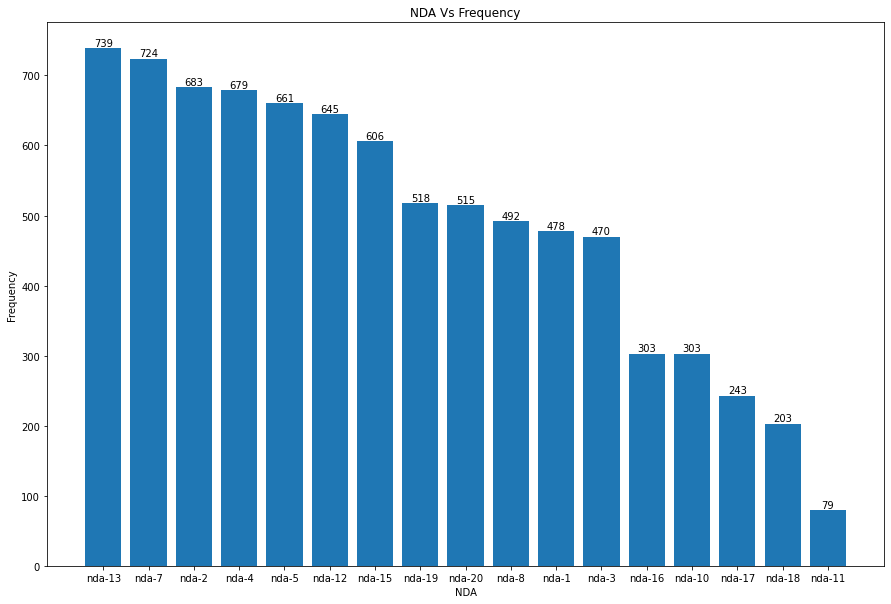

In [36]:
def get_nda_count(document_annotations):
  nda_counts_dict = {}

  for key, value in document_annotations.items():
      for nda, nda_count in value.items():
          if nda not in nda_counts_dict:
              nda_counts_dict[nda] = nda_count
          else:
              nda_counts_dict[nda] += nda_count

  return nda_counts_dict


def plot_nda(nda_counts_dict):
  sorted_nda=dict(sorted(nda_counts_dict.items(), key=lambda item: item[1], reverse=True))
  plt.subplots(figsize=(15,10))
  plt.bar(range(len(sorted_nda)), list(sorted_nda.values()))
  plt.xticks(range(len(sorted_nda)), list(sorted_nda.keys()))
  plt.title("NDA Vs Frequency")
  plt.xlabel("NDA")
  plt.ylabel("Frequency")
  for i, v in enumerate(sorted_nda.values()):
        plt.text(i, v + 3, str(v), ha='center')
  plt.show()

nda_counts=get_nda_count(document_annotations)
plot_nda(nda_counts)